In [37]:
import numpy as np
import scipy.integrate as integrate
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
import scipy.interpolate
import time
from scipy.optimize import curve_fit
import math
import OuputFunction

In [38]:
"""
Plot Settings
"""

import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.ticker as mticker
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
%matplotlib inline
mpl.style.use('default')

myColors = ["#009E73", "#0072B2", "#CC79A7", "#D55E00", "#56B4E9", "#F0E442", "#E69F00", "#000000"]
colors= ["white", myColors[4], myColors[1], myColors[0], myColors[5], myColors[6], myColors[3]]
myNodes = [0.0, 0.1, 0.2, 0.35, 0.5, 0.85, 1.0]
myCmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(myNodes, colors)))

colorsLog= ["white",  myColors[4], myColors[1], myColors[6], myColors[3], myColors[3]]
myNodesLog = [0.0, 0.1 , 0.2, 0.36, 0.6, 1]
myCmapLog = mpl.colors.LinearSegmentedColormap.from_list("mycmapLog", list(zip(myNodesLog, colorsLog)))

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams.update({
	'font.family':'serif',
	'mathtext.fontset' : 'cm',
	'mathtext.rm': 'serif',
	'font.weight': 'normal',
	})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 
plt.rcParams.update({'font.size': 15})

mpl.rcParams['axes.prop_cycle'] = cycler(color=myColors)

path_image = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/P-S/P-S/Outputs/'

In [39]:
"""
Define our cosmological context from Planck 18:1807.06209
"""

H0= (67.66 * u.km * u.s**-1 * u.Mpc**-1).to(u.yr**-1).value
omega_m = 0.3103
omega_l = 0.6897
Rsun = 696340*u.km
Msun= constants.M_sun
c=constants.c.to(u.km/u.s)
G=constants.G.to(u.km**3/u.s**2/u.kg)

From Susa 2014 (10.1088/0004-637X/792/1/32), we determine the number of PopIII we will generate per halos


In [40]:
"""
Import Data from Susa
"""
pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/P-S/P-S/PopIII_data/Susa2014/'
name_N_per_halo = 'Stars_per_minihalo'
N_per_halos = np.rint(np.genfromtxt(pathfit_susa + 'N_per_halos' +'.csv'))
x_bins=np.arange(1,7,1)

In [41]:
"""
Definition the PDF
"""
PowerLaw = OuputFunction.PowerLaw
PowerLaw_norm = OuputFunction.PowerLaw_norm

x_fit_NH = np.arange(1, 7, 0.1)
sample=[]
popt, pcov = curve_fit(PowerLaw, x_bins, N_per_halos,  bounds=([18, 0], [30, 10]))
y_fit_NH = PowerLaw(x_fit_NH, *popt)
A, a = popt
N_tot = np.sum(N_per_halos)

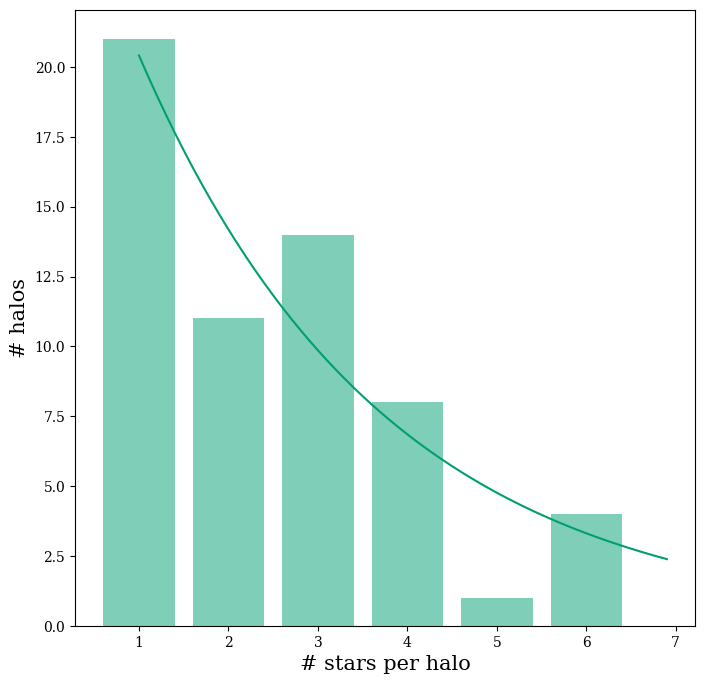

In [42]:
plt.subplots(figsize=(8,8))
plt.bar(x_bins, N_per_halos, alpha = 0.5)
plt.plot(x_fit_NH, y_fit_NH, color=myColors[0])

plt.xlabel('# stars per halo')
plt.ylabel('# halos')
plt.savefig(path_image+'number_of_stars.png', dpi=500)

In [43]:
N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
N_per_halos_N = N_per_halos/N_NH

popt10, pcov10 = curve_fit(PowerLaw_norm, x_bins, N_per_halos_N,  bounds=([0, 0], [30, 10]))

A10, a10 = popt10

n = np.linspace(0.5, 7.5, 100)

"""
We use an interpolate 1d to avoid integrate the norm at each step to optimize the computation and we vectorize it to use it with datasets
"""

N_star_prob = scipy.interpolate.interp1d(n, PowerLaw(n, A10, a10), kind='cubic')

def N_star_pdf(n_s):
    n = np.vectorize(N_star_prob)
    return n(n_s)

Now that we have our first PDF that give us the number of star per halo, we use it to build a monte carlo that return the number of star par mass of halos with an associated mass. 
To do so we need the IMF of the halos' masses.

In [44]:
"""
GrowthFunction is the class that define the evolution of the Universe while HaloMassFunction is the class that create the Halos' IMF in this universe
"""
from PS_class import HaloMassFunction
from PS_class import GrowthFunction

In [45]:
"""
Settings of the halos IMF
"""
HMF = HaloMassFunction(0, logmass_lim=(4, 20), Nbins=100)
gf = GrowthFunction
gen = np.random.default_rng()

H_IMF = HMF.IMF

z = np.linspace(10, 30, 100)
Mh_interval=(10**4, 10**8)
m = np.logspace(np.log10(Mh_interval[0]), np.log10(Mh_interval[1]), 100)

In [46]:
"""
Building of the Halo IMF in terms of mass and z (again we use the interpolator and vectorize for the same reasons)
"""

xh, yh = np.meshgrid(m, z)

h = H_IMF(xh, yh)

h_inter = scipy.interpolate.interp2d(m, z, h, kind='cubic')

def halo_PDF_norm(z):
    return integrate.quad(h_inter, 1e4, Mh_interval[1], args=(z), epsrel=1e-2, limit=1000)[0]

In [47]:
"""
Build of the Halo generator from Halo IMF. Uncomment the code for time computing information
"""
def HalosGenerator(M_max, z):

    norm = halo_PDF_norm(z)

    def pdf(m):
        return h_inter(m, z)/norm
    
    m_int = np.logspace(4, 10, 100)
    pdf_int = scipy.interpolate.interp1d(m_int, pdf(m_int))

    fmax=pdf_int(Mh_interval[0])+0.02*pdf_int(Mh_interval[0])
    x_output=np.array([])
    
    m=0
    #t=[]
    while m<M_max:

        # t0 = time.time()
        # t.append(time.time()-t0)

        x = gen.uniform(*Mh_interval, 10000)
        y = gen.uniform(0, fmax, 10000)

        x_accepted = x[(y <= pdf_int(x))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        m+=np.sum(x_accepted)

        

        # if(ii>=100):
        #     t_tot =np.mean(t)*ninput
        #     print(" Time for 1 loop is approx:", np.mean(t)
        #         , "\n Comp is finished in ", t_tot, "s"
        #         , " = " , t_tot/60 , "min" )
    
    return x_output

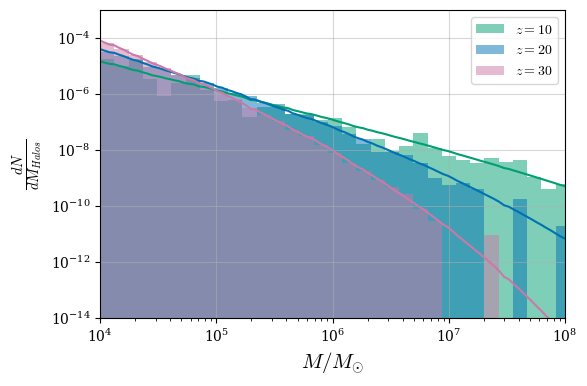

In [48]:
"""
Plots of the generation of the Halo IMF
"""

plt.subplots(figsize=(6,4))
plt.grid(alpha = 0.5)
m = np.logspace(4, 8, 100)
for i in range(1,4):
    h = HalosGenerator(1e9, i*10)
    imf_h = HMF.IMF(m, i*10)/halo_PDF_norm(i*10)
    plt.hist(h, bins=np.logspace(4, 10, 50), density=True, alpha = 0.5, label = f'$z={i*10}$', color = myColors[i-1])
    plt.plot(m, imf_h, color = myColors[i-1])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(1e4, 1e8)
plt.ylim(1e-14, 1e-3)
plt.xlabel(r'$M/M_{\odot}$')
plt.ylabel(r'$\frac{dN}{dM_{Halos}}$')

plt.savefig(path_image+'Halo_generation.png', dpi=500, bbox_inches="tight")

In [49]:
"""
Build of the generator of PopIII in halos depending of their mass
"""

def N_StarGenerator(m_Hs, f):

    fmax=N_star_pdf(0.5)+0.02*N_star_pdf(0.5)
    x_output=np.array([])
    y_output=np.array([])

    ninput=len(m_Hs)
    
    ii = 0
    while ii<ninput:

        x = gen.uniform(0.5, 7.5, ninput)
        y = gen.uniform(0, fmax, ninput)

        x_accepted = x[(y <= N_star_pdf(x))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        y_accepted = y[(y <= N_star_pdf(x))]
        y_output = (np.append(y_output, y_accepted)).flatten()
        ii+=len(x_accepted)

        x_output = x_output[:ninput]
        y_output = y_output[:ninput]
        
    
    return (np.rint((m_Hs/10**6)**f*x_output)).astype(int)

    


Now we need the IMF of the Pop III. We use the results of 3 differents papers, Stacy 2015, Susa 2014, and Hirano 2015

In [50]:
RescalingCenters = OuputFunction.RescalingCenters
HistMaker = OuputFunction.HistMaker
Gaussian = OuputFunction.Gaussian
Double_Gaussian = OuputFunction.Double_Gaussian

In [51]:
#Hirano 2015
name_Hirano2015 = ['Total', '10<z<14', '14<z<18', '18<z<22', '22<z<26', '26<z<30', 'Bins']

pathfit_Hirano2015= '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/P-S/P-S/PopIII_data/Hirano2015/'
Hirano2015 = np.empty(len(name_Hirano2015), dtype=object)
for i in range(len(name_Hirano2015)):
    Hirano2015[i] = np.genfromtxt(pathfit_Hirano2015 + name_Hirano2015[i] +'.csv', delimiter=';')

Nbins_Hirano2015 = len(Hirano2015[0])
Bins_Hirano2015_min = min(Hirano2015[-1][:,0])
Bins_Hirano2015_max = max(Hirano2015[-1][:,0])
Bins_limit_Hirano2015=(Bins_Hirano2015_min, Bins_Hirano2015_max)


Hirano2015_Y=np.empty(len(Hirano2015), dtype=object)
Hirano2015_edges = np.empty(len(Hirano2015), dtype=object)
Hirano2015_centers = np.empty(len(Hirano2015), dtype=object)
Data_Hirano2015 = np.empty(len(Hirano2015), dtype=object)

for i in range(len(Hirano2015)):
    Hirano2015_edges[i], Hirano2015_centers[i], Hirano2015_Y[i] = RescalingCenters(Hirano2015[i], Nbins_Hirano2015, Bins_limit=Bins_limit_Hirano2015)
    Data_Hirano2015[i]= HistMaker(Hirano2015_edges[i], Hirano2015_centers[i], Hirano2015_Y[i])


(0.9911086115606538, 2.324458683825721e-09)
[0.11683528 1.3816745  1.40116422 0.25327232 2.18074878 0.91478506]
(0.9401219023557018, 2.246588450197768e-09)
[0.14016337 2.         0.53677288 0.1554906  2.35955187 1.92820967]
[0.15636607 2.43724364]
[0.09545854 2.51981353]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.125979   2.52119741]


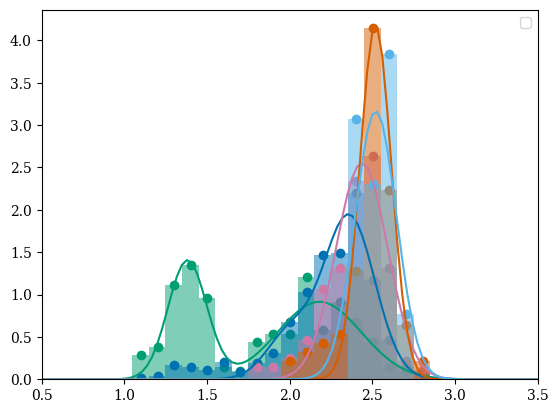

In [52]:
Hirano2015_popts = np.empty(5, dtype=object
                            )
for i in range(1, len(Data_Hirano2015)-1):
    mfit_pop3_h2015 = np.linspace(0.5, 3.5, 100)
    bin_entries, _, _  = plt.hist(Data_Hirano2015 [i], bins=np.linspace(np.log10(Bins_limit_Hirano2015[0]), np.log10(Bins_limit_Hirano2015[1]), 21), alpha = 0.5, density=True, color=myColors[i-1])   

    mask=(Hirano2015_Y[i]!=0)
    Hirano2015_centerf = np.log10(Hirano2015_centers[i])[mask]
    plt.scatter(np.log10(Hirano2015_centers[i])[mask], bin_entries[mask], color=myColors[i-1])


    if i<3:
        Hirano2015_popts[i-1], Hirano2015_pcov = curve_fit(Double_Gaussian, Hirano2015_centerf, bin_entries[mask], bounds=([0, 1, 0, 0, 2, 0],[1, 2, 10, 1, 3, 10]))
        s1, mu1, A1, s2, mu2, A2 = Hirano2015_popts[i-1]
        norm = integrate.quad(Double_Gaussian, 0.5, 3.5, args = (s1, mu1, A1, s2, mu2, A2, ))
        print(norm)
        plt.plot(mfit_pop3_h2015, Double_Gaussian(mfit_pop3_h2015, *Hirano2015_popts[i-1]), color=myColors[i-1])
    elif i>=3:
        Hirano2015_popts[i-1], Hirano2015_pcov = curve_fit(Gaussian, Hirano2015_centerf, bin_entries[mask], bounds=([0,2],[1, 3]))
        plt.plot(mfit_pop3_h2015, Gaussian(mfit_pop3_h2015, *Hirano2015_popts[i-1]), color=myColors[i-1])
    
    print(Hirano2015_popts[i-1]) 

# plt.ylim(1, 1000)
plt.xlim(0.5, 3.5)
# plt.yscale('log')
plt.legend()

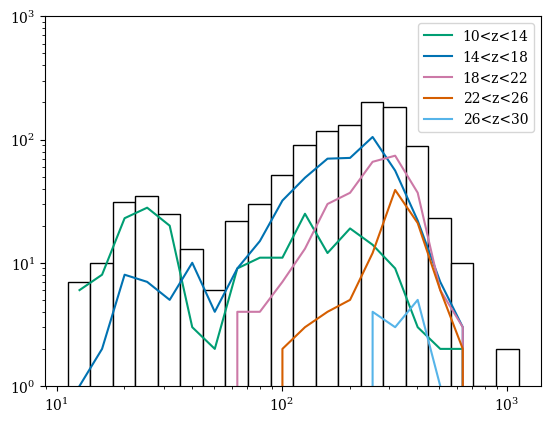

In [53]:
plt.bar(Hirano2015_edges[0][:-1], Hirano2015_Y[0], width=np.diff(Hirano2015_edges[i]), ec="k", align="edge", color='white')
for i in range(1, len(Hirano2015)-1):
    plt.plot(Hirano2015_centers[i], Hirano2015_Y[i], label=f'{name_Hirano2015[i]}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1, 1000)
plt.legend()

In [54]:
"""
Hirano 2015 is the only one depending on z
"""

s1, mu1, A1, s2, mu2, A2 = Hirano2015_popts[0]
norm1 = integrate.quad(Double_Gaussian, 0.5, 3.5, args = (s1, mu1, A1, s2, mu2, A2, ))[0]
s1, mu1, A1, s2, mu2, A2 = Hirano2015_popts[1]
norm2 = integrate.quad(Double_Gaussian, 0.5, 3.5, args = (s1, mu1, A1, s2, mu2, A2, ))[0]

def hirano2015_pdf(M, z):
    if 10<=z and z<14:
        return Double_Gaussian(np.log10(M), *Hirano2015_popts[0])/norm1
    elif 14<=z and z<18:
        return Double_Gaussian(np.log10(M), *Hirano2015_popts[1])/norm2
    elif 18<=z and z<22:
        return Gaussian(np.log10(M), *Hirano2015_popts[2])
    elif 22<=z and z<26:
        return Gaussian(np.log10(M), *Hirano2015_popts[3])
    elif 26<=z and z<=30:
        return Gaussian(np.log10(M), *Hirano2015_popts[4])

Hirano2015_pdf = np.vectorize(hirano2015_pdf)
    



In [55]:
#Susa 2014
pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/P-S/P-S/PopIII_data/Susa2014/'
name_susa = ['Bins edges', 'Hist']

Susa = np.genfromtxt(pathfit_susa + name_susa[1] +'.csv', delimiter=';')
Bins_limit_Susa=np.genfromtxt(pathfit_susa + name_susa[0] +'.csv', delimiter=';')[:,0].tolist()
Nbins_Susa = 20
Bins_limit_Susa

[0.464926482, 295.3916929]

In [56]:
Susa_edge, Susa_center, Susa_Y = RescalingCenters(Susa, Nbins_Susa, Bins_limit=Bins_limit_Susa)
Data_Susa_i = HistMaker(Susa_edge, Susa_center, Susa_Y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.52420984 1.38007314]


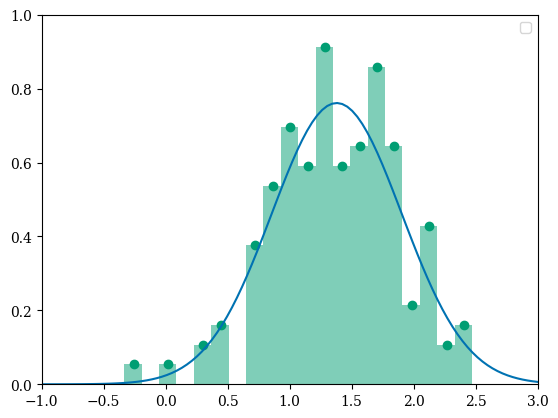

In [57]:
mfit_pop3 = np.linspace(-1, 3, 100)
bin_entries, _, _  = plt.hist(Data_Susa_i, bins=np.linspace(np.log10(Bins_limit_Susa[0]), np.log10(Bins_limit_Susa[1]), 21), alpha = 0.5, density=True)   

mask=(Susa_Y!=0)
Susa_centerf = np.log10(Susa_center)[mask]
plt.scatter(np.log10(Susa_center)[mask], bin_entries[mask])

Susa_popt, Susa_pcov = curve_fit(Gaussian, Susa_centerf, bin_entries[mask], bounds=([0,0],[10, 2]))

plt.plot(mfit_pop3, Gaussian(mfit_pop3, *Susa_popt))
print(Susa_popt) 

plt.ylim(0, 1)
plt.xlim(-1, 3)
plt.legend()

In [58]:
"""
We ask for z in the definition of the PDF from Susa and Stacy even if its not required. It's for the routine that we will create in the halo to simplify the coding
"""
def Susa_IMF_PDF(m, z):
    return Gaussian(np.log10(m), *Susa_popt)

def Susa_IMF_PDF_log(logm, z):
    """
    this pdf is normlaized only for the log of the mass!
    """
    return Gaussian(logm, *Susa_popt)


In [59]:
#Stacy 2016
def Stacy_PDF(M, z):
    return M**-1.13/10

def Stacy_PDF_log(M, z):
    return M**-0.13

In [60]:
from scipy.stats import loguniform

"""
Generator of PopIII masses working for each popIII IMF
"""

def Mass_Star_Generator(ninput, z, PDF, m_interval):
    m_max = np.logspace(np.log10(m_interval[0]),  np.log(m_interval[1]), 100)
    pdfmax = np.max(PDF(m_max, z))
    fmax = pdfmax+0.02*pdfmax
    x_output = np.array([])
    
    ii = 0
    while ii<ninput:

        x = loguniform.rvs(m_interval[0], m_interval[1], size=ninput)
        y = gen.uniform(0, fmax, ninput)

        x_accepted = x[(y <= PDF(x, z))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        ii+=len(x_accepted)

        x_output = x_output[:ninput]
    
    return x_output


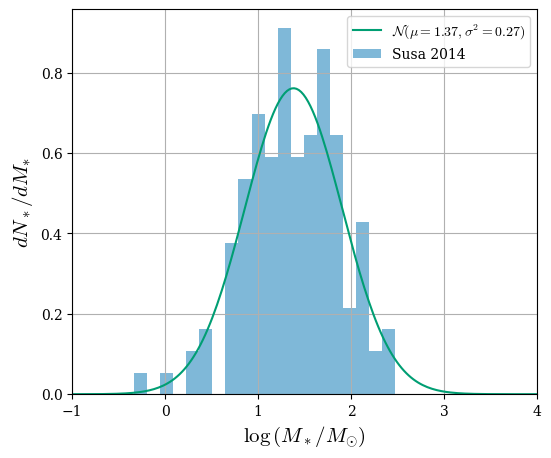

In [61]:
plt.subplots(figsize=(6,5))
plt.grid()
m = np.linspace(-1, 4, 200)

plt.plot(m, Susa_IMF_PDF_log(m, 10), label = "$\mathcal{N}(\mu = 1.37, \sigma^2 = 0.27)$")
plt.hist(Data_Susa_i, bins=np.linspace(np.log10(Bins_limit_Susa[0]), np.log10(Bins_limit_Susa[1]), 21), alpha = 0.5, density=True, label = 'Susa 2014')   
plt.xlim(-1,4)
plt.xlabel('$\log{(M_*/M_{\odot})}$')
plt.ylabel('$dN_*/dM_{*}$')
# plt.xscale('log')
plt.legend()
plt.savefig(path_image+'Susa_Datas.png', dpi=500, bbox_inches="tight")


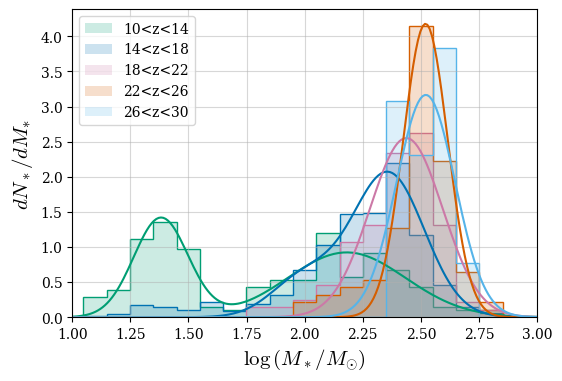

In [62]:
z = [10, 14, 18, 22, 26]
plt.subplots(figsize=(6,4))
plt.grid(alpha = 0.5)
m = np.logspace(1, 3, 200)

for i in range(len(z)):
    
    star_hirano = Mass_Star_Generator(10000, z[i], Hirano2015_pdf, (10, 1000))
    # plt.hist(np.log10(star_hirano), density=True, bins=45, alpha = 0.2, color = myColors[i], label = f'$z = {z[i]}$')
    plt.plot(np.log10(m), Hirano2015_pdf(m, z[i]), color = myColors[i])
    hist, bin_edges = np.histogram(Data_Hirano2015 [i+1], bins=np.linspace(np.log10(Bins_limit_Hirano2015[0]), np.log10(Bins_limit_Hirano2015[1]), 21), density=True)  
    bins_centers = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(20)])
    plt.bar(bins_centers, hist, width=np.diff(bin_edges), color = myColors[i], label = name_Hirano2015[i+1], alpha =0.2)
    plt.stairs(hist, bin_edges, color = myColors[i])
    
plt.xlim(1,3)
plt.xlabel('$\log{(M_*/M_{\odot})}$')
plt.ylabel('$dN_*/dM_{*}$')
# plt.xscale('log')
plt.legend()
plt.savefig(path_image+'hirano_Datas.png', dpi=500, bbox_inches="tight")

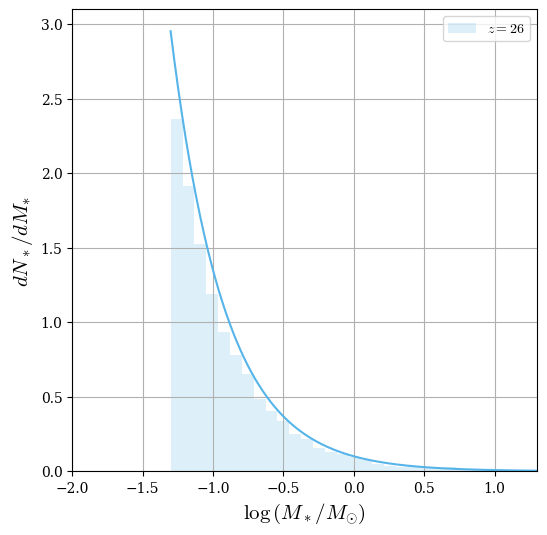

In [63]:
plt.subplots(figsize=(6,6))
plt.grid()
m = np.logspace(np.log10(0.05), np.log10(20), 200)
star_stacy = Mass_Star_Generator(10000, z[i], Stacy_PDF, (0.05, 20))
plt.hist(np.log10(star_stacy), density=True, bins = 30, alpha = 0.2, color = myColors[i], label = f'$z = {round(z[i],2)}$')
plt.plot(np.log10(m), Stacy_PDF(m, z[i]), color = myColors[i])
plt.xlim(np.log10(0.01), np.log10(20))
plt.xlabel('$\log{(M_*/M_{\odot})}$')
plt.ylabel('$dN_*/dM_{*}$')
# plt.xscale('log')
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.savefig(path_image+'Stacy_Datas.png', dpi=500)

46 44


(1000000.0, 100000000000.0)

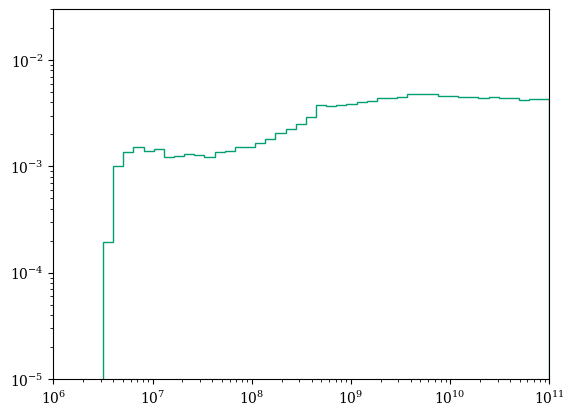

In [64]:
"""
IMF of the PopIII's BH remnant from Tanikawa serving as reference for this work
"""

path_tanikawa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/P-S/P-S/PopIII_data/'

Tanikawa = np.genfromtxt(path_tanikawa + 'Tanikawa' +'.csv', delimiter=';')
Bins_loglimit_Tanikawa = (6.5, 11)
Nbins_Tanikawa= 20
Tanikawa2 = Tanikawa[1: -1]
print(len(Tanikawa), len(Tanikawa2))
plt.stairs(Tanikawa2[:,1], np.logspace(6.5, 11, 45))
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 3e-2)
plt.xlim(1e6, 1e11)

In [65]:
def Time_z(z):
    a = 1/(1 + z)
    denom = H0*3*np.sqrt(a * omega_l * (a**3 * omega_l + omega_m) / a)
    num = 2 * np.sqrt(a**3 * omega_l + omega_m) * np.arctanh(np.sqrt(a**3 * omega_l / (a**3 * omega_l + omega_m)))

    return num / denom


def Redshift_t(t):
    denom = (omega_l - omega_l * np.tanh(3 / 2 * H0 * t * np.sqrt(omega_l))**2)**(1/3)
    num = omega_m**(1/3) * np.tanh(3 / 2 * H0 * t * np.sqrt(omega_l))**(2/3)
    return denom/num-1


In [66]:
"""
Generator of the binaries among the generated PopIII
"""

norm_a = integrate.quad(lambda k: 1/k, 6957000, 2000*695700)[0]

def a_pdf(x):
    return 1/x/5.298317366548035

def a_generator(n, amin):
    amin = amin
    fmax = a_pdf(amin)+0.01*a_pdf(amin)
    ii=0
    x_output=np.array([])
    while ii<n:
        y = np.random.uniform(0, fmax, 1000)
        x = np.random.uniform(amin, 2000*695700, 1000)
        mask = y<a_pdf(x)
        x_output = np.append(x_output, x[mask])
        ii+=len(x[mask])
    return x_output[:n][0]

def e_pdf(e, ai, amin):
    return e/(1/2 * math.pow((1 - amin/ai), 2))

def e_generator(n, ai, amin):
    emax = 1 - amin/ai
    fmax = 2/emax+0.01*2/emax
    ii=0
    x_output=np.array([])
    while ii<n:
        y = np.random.uniform(0, fmax, 1000)
        x = np.random.uniform(0, emax, 1000)
        mask = y<e_pdf(x, ai, amin)
        x_output = np.append(x_output, x[mask])
        ii+=len(x[mask])
    return x_output[:n][0]

In [67]:
def g_e(e):
    return (1-e**2)**(7/2)/(1+(73/24)*e**2+(37/96)*e**4)

"""
Merging time of the BH depending of their masses
"""
def Merging_Time(M1, M2, dt):

    M1 = max((M1, M2))
    M2 = min((M1, M2))

    M1 = M1*Msun
    M2 = M2*Msun

    q= (M2/M1).value

    R1 = (0.28*Rsun*(M1/Msun)**0.61)

    amin2 = ((0.6 * math.pow(q, 2/3) + np.log(1 + math.pow(q, 1/3))) / (0.49 * math.pow(q, 2/3)) * R1 / Rsun).value
    
    amin= max((6957000., amin2))

    a = a_generator(1, amin)
    e = e_generator(1, a, amin)
    
    t = (((5/256) * (c**5/G**3*(a*u.km)**4)/(M1*M2*(M1+M2))*g_e(e)).to(u.yr)).value + dt
    return t

_ = g_e(0.9)
_ = Merging_Time(1e6, 1e6, 1e6)


In [68]:
"""
First routine of the simulation! We create the time step in the redshift depending on the collapsing time dt of the popIII due to ADM accretion
"""

def Redshift_routine(z_i, z_f, dt):

    t_i = Time_z(z_i)
    t_f = Time_z(z_f)
    
    def redhsift_steps(step_number, dt, n_step):
        if step_number <= n_step:
            steped_time = t_i + step_number*dt
            return Redshift_t(steped_time)
        else:
            return False

    n_step = int(np.rint((t_f - t_i)/dt))
    print('There will be ', n_step, 'steps')
    z = []
    simulation_finished = True

    i = 0
    while simulation_finished:
        simulation_finished = redhsift_steps(i, dt, n_step)
        z.append(simulation_finished)
        if not simulation_finished:
            z = z[:-2]
        i+=1

    return z


In [69]:
"""
Second routine ! We generate the binaries in the halo at each time step: 
    1. Generate the mass from the halo IMF depending on the time
    2. Generate the number of PopIII (binaries) in each halo depending on the mass of the halos 
    3. Generate the good amount of binaries' masses for each halo (depending on z for Hirano 2015)
    4. Comput the Merging time, coalescent time, etc.
"""
def Routine(z, PopIII_PDF, f, m_interval, dt):
    
    M1_z = []
    M2_z = []
    z_merge = []
    t_merge = []
    t_coal_merge = []
    chirp_mass_z = []
    eta_bin_z = []
    m_mean_z = []

    t_0 = Time_z(0)

    for i in range(len(z)):
        Halos = HalosGenerator(1e9, z[i])
        Ns = N_StarGenerator(Halos, f)
        m_popIIIs = []
        for n in Ns:
            m_popIIIs = np.concatenate((m_popIIIs, Mass_Star_Generator(n, z[i], PopIII_PDF, (m_interval[0], m_interval[1])).tolist()))

        n = len(m_popIIIs)

        M1=[]
        M2=[]
        binaries = []
        z_binaries = []
        t_binaries = []
        
        
        for s in range(int(n/4)):
            M1.append(m_popIIIs[2*s])
            M2.append(m_popIIIs[2*s+1])

            t = Merging_Time(m_popIIIs[2*s], m_popIIIs[2*s+1], dt)

            
            binaries.append(np.log10(t))
            z_binaries.append(Redshift_t(Time_z(z[i])+t))
            t_binaries.append(Time_z(z[i])+t)

        mask = (10**np.array(binaries) < t_0)
        
        M1_z.append(np.array(M1)[mask].tolist())
        M2_z.append(np.array(M2)[mask].tolist())
        t_coal_merge.append(np.array(binaries)[mask].tolist())
        z_merge.append(np.array(z_binaries)[mask].tolist())
        t_merge.append(np.array(t_binaries)[mask].tolist())
        
    return M1_z, M2_z, z_merge, t_merge, t_coal_merge

In [70]:
"""
This function initiate the routine for a given set of parameters. This is use to compare the different cosmological context
"""
def Computer(f, dt, zi, zf, IMF, IMF_born):

    z = Redshift_routine(zi, zf, dt)

    M1_z, M2_z, z_merge, t_merge, t_coal_merge = Routine(z, IMF, f, IMF_born, dt)

    merge_z_datas = np.concatenate(z_merge) 
    merge_t_datas = np.concatenate(t_merge) 
    M_tot = np.array(M1_z, dtype=object) + np.array(M2_z,dtype=object)

    return merge_z_datas, merge_t_datas, t_coal_merge, M_tot

Now everything is set to start simulating, we use different set of parameters at the beginning of each cells

In [71]:
f = 1
dt = 1e7
zi = 30

zs_Susazf = []
ts_Susazf =[]
coal_time_datas_Susazf = []
M_tot_Susazf =[]


for i in range(0,3):
    
    zf = 10+5*i

    merge_z_datas, merge_t_datas, coal_time_datas, M_tot= Computer(f, dt, zi, zf, Susa_IMF_PDF, (0.1, 1000))

    zs_Susazf.append(merge_z_datas)
    ts_Susazf.append(merge_t_datas)
    coal_time_datas_Susazf.append(coal_time_datas)
    M_tot_Susazf.append(M_tot)


There will be  37 steps


KeyboardInterrupt: 

In [ ]:
dt = 1e7
zi = 30
zf=10


zs_Susaf = []
ts_Susaf =[]
coal_time_datas_Susaf = []
M_tot_Susaf =[]


for i in range(0,3):
    
    f = 1/10**(2*i)

    merge_z_datas, merge_t_datas, coal_time_datas, M_tot = Computer(f, dt, zi, zf, Susa_IMF_PDF, (0.1, 1000))

    zs_Susaf.append(merge_z_datas)
    ts_Susaf.append(merge_t_datas)
    coal_time_datas_Susaf.append(coal_time_datas)
    M_tot_Susaf.append(M_tot)

There will be  37 steps
There will be  37 steps
There will be  37 steps


In [ ]:
f = 1
zi = 30
zf=10

zs_Susadt = []
ts_Susadt =[]
coal_time_datas_Susadt = []
M_tot_Susadt =[]

for i in range(6,9):

    dt = 10**i

    merge_z_datas, merge_t_datas, coal_time_datas, M_tot = Computer(f, dt, zi, zf, Susa_IMF_PDF, (0.1, 1000))

    zs_Susadt.append(merge_z_datas)
    ts_Susadt.append(merge_t_datas)
    coal_time_datas_Susadt.append(coal_time_datas)
    M_tot_Susadt.append(M_tot)

There will be  374 steps
There will be  37 steps
There will be  4 steps


In [ ]:
dt = 1e7
zi = 30
f=1

zs_Hzf = []
ts_Hzf =[]
coal_time_datas_Hzf = [] 
M_tot_Hzf = []

for i in range(0,3):
    
    zf=10+5*i

    merge_z_datas, merge_t_datas, coal_time_datas, M_tot= Computer(f, dt, zi, zf, Hirano2015_pdf, (10**0.5, 10**3.5))

    zs_Hzf.append(merge_z_datas)
    ts_Hzf.append(merge_t_datas)
    coal_time_datas_Hzf.append(coal_time_datas)
    M_tot_Hzf.append(M_tot)



There will be  37 steps
There will be  17 steps
There will be  8 steps


In [ ]:
zi = 30
zf=10
f=1

zs_Hdt = []
ts_Hdt =[]
coal_time_datas_Hdt = []
M_tot_Hdt = []


for i in range(6,9):

    dt = 10**i

    merge_z_datas, merge_t_datas, coal_time_datas, M_tot = Computer(f, dt, zi, zf, Hirano2015_pdf, (10**0.5, 10**3.5))

    zs_Hdt.append(merge_z_datas)
    ts_Hdt.append(merge_t_datas)
    coal_time_datas_Hdt.append(coal_time_datas)
    M_tot_Hdt.append(M_tot)


There will be  374 steps


KeyboardInterrupt: 

In [ ]:
dt = 1e7
zi = 30
zf=10

zs_Hf = []
ts_Hf =[]
coal_time_datas_Hf = []
M_tot_Hf = []


for i in range(0,3):
    
    f = 1/10**(2*i)

    merge_z_datas, merge_t_datas, coal_time_datas, M_tot = Computer(f, dt, zi, zf, Hirano2015_pdf, (10**0.5, 10**3.5))

    zs_Hf.append(merge_z_datas)
    ts_Hf.append(merge_t_datas)
    coal_time_datas_Hf.append(coal_time_datas)
    M_tot_Hf.append(M_tot)  

In [ ]:
f = 1
dt = 1e7
zi = 30


zs_Stacyzf = []
ts_Stacyzf =[]
coal_time_datas_Stacyzf = []
M_tot_Stacyzf = []

for i in range(0,3):
    
    zf = 10+5*i

    merge_z_datas, merge_t_datas, coal_time_datas, M_tot = Computer(f, dt, zi, zf, Stacy_PDF, (0.5, 20))

    zs_Stacyzf.append(merge_z_datas)
    ts_Stacyzf.append(merge_t_datas)
    coal_time_datas_Stacyzf.append(coal_time_datas)
    M_tot_Stacyzf.append(M_tot)

In [ ]:
f = 1
zi = 30
zf = 10

zs_Stacydt = []
ts_Stacydt =[]
coal_time_datas_Stacydt = []
M_tot_Stacydt = []

for i in range(6,9):

    dt = 10**i
    
    merge_z_datas, merge_t_datas, coal_time_datas, M_tot = Computer(f, dt, zi, zf, Stacy_PDF, (0.5, 20))

    zs_Stacydt.append(merge_z_datas)
    ts_Stacydt.append(merge_t_datas)
    coal_time_datas_Stacydt.append(coal_time_datas)
    M_tot_Stacydt.append(M_tot)


In [ ]:
zi = 30
zf = 10
dt=1e7

zs_Stacyf = []
ts_Stacyf =[]
coal_time_datas_Stacyf = []
M_tot_Stacyf = []

for i in range(0,3):

    f = 1/10**(2*i)
    
    merge_z_datas, merge_t_datas, coal_time_datas, M_tot= Computer(f, dt, zi, zf, Stacy_PDF, (0.5, 20))

    zs_Stacyf.append(merge_z_datas)
    ts_Stacyf.append(merge_t_datas)
    coal_time_datas_Stacyf.append(coal_time_datas)
    M_tot_Stacyf.append(M_tot)

In [ ]:
"""
The simulation is completed. We create big list to start the output plots
"""

Zs_list = [[zs_Susazf, zs_Hzf, zs_Stacyzf], [zs_Susaf, zs_Hf, zs_Stacyf], [zs_Susadt, zs_Hdt, zs_Stacydt]]
Ts_list = [[ts_Susazf, ts_Hzf, ts_Stacyzf], [ts_Susaf, ts_Hf, ts_Stacyf], [ts_Susadt, ts_Hdt, ts_Stacydt]]
coal_time_datas_list = [[coal_time_datas_Susazf, coal_time_datas_Hzf, coal_time_datas_Stacyzf], [coal_time_datas_Susaf, coal_time_datas_Hf, coal_time_datas_Stacyf], [coal_time_datas_Susadt, coal_time_datas_Hdt, coal_time_datas_Stacydt]]
M_tot_list = [[M_tot_Susazf, M_tot_Hzf, M_tot_Stacyzf],[M_tot_Susaf, M_tot_Hf, M_tot_Stacyf],[M_tot_Susadt, M_tot_Hdt, M_tot_Stacydt]]

In [ ]:
"""
Some function to format the datasets
"""

binnage = OuputFunction.binnage
output_prep = OuputFunction.output_prep

In [ ]:
"""
Plot functions.
"""

def Output(zs_list, ts_list, coal_time_datas_list, M_tot_list, AX, BX, CX, DX, EX, c_z, c_mtot):

    f =1 
    dt =1e6
    zf=20

    CX[0,0].stairs(np.array(Tanikawa2[:,1])*100, np.linspace(6.5, 11, 45), color = 'k', label = 'Tanikawa 2020')
    CX[0,0].legend()

    for i in range(3):

        for j in range(3):

            AX[i,j].grid(alpha = 0.5)
            BX[i,j].grid(alpha = 0.5)
            CX[i,j].grid(alpha = 0.5)
            DX[i,j].grid(alpha = 0.5)
            EX[i,j].grid(alpha = 0.5)

            for k in range(3):

                if i==0:
                    zf = 15+5*k
                elif i==1:
                    f = 1/10**(2*k)
                elif i==2:
                    dt = 10**(5+k)

                labels =[f"$z_f = {zf}$", f"$f = {f}$", f"$dt = 10^{5+k} yr$"]

                output_prep(zs_list[i][j][k], ts_list[i][j][k], coal_time_datas_list[i][j][k], M_tot_list[i][j][k], dt, labels[i], myColors[k], AX[i][j], BX[i][j], CX[i][j], DX[i][j], EX[i][j], c_z[j], c_mtot[j])

            CX[i,j].stairs(np.array(Tanikawa2[:,1])*100, np.linspace(6.5, 11, 45), color = 'k')
            AX[i,j].set_xscale('log')
            AX[i,j].set_yscale('log')

            CX[i,j].set_yscale('log')

            DX[i,j].set_yscale('log')
            DX[i,j].set_xlim(3, 11)

            EX[i,j].set_xscale('log')

        
    AX[2,1].set_xlabel(r"$t_{BH-BH}$ $[$yr$]$")
    AX[1,0].set_ylabel(r'$\frac{dN_{BH-BH}}{dt_{BH-BH}}$')

    BX[2,1].set_xlabel(r'$z_{BH-BH}$')
    BX[1,0].set_ylabel(r'$\frac{dN_{BH-BH}}{dz_{BH-BH}}/c_{max}$')

    CX[2,1].set_xlabel(r'$\log{(\tau_d)}$ [yr]')
    CX[1,0].set_ylabel(r'$\frac{dN_{BH-BH}}{d\log{(\tau_d)}}$')

    DX[2,1].set_xlabel(r'$\log{(\tau_{coal})} [yr]$')
    DX[1,0].set_ylabel(r'$\frac{dN_{BH-BH}}{d\log{(\tau_{coal})}}$')
    

    EX[2,1].set_xlabel(r'$M_{tot}}$')
    EX[1,0].set_ylabel(r'$\frac{dN_{BH-BH}}{dM_{tot}}/c_{max}$')

    return 


In [ ]:
fig1, AX = plt.subplots(3, 3, figsize = (8, 8), sharex=True, sharey=True)
fig2, BX = plt.subplots(3, 3, figsize = (8, 8), sharex=True, sharey=True)
fig3, CX = plt.subplots(3, 3, figsize = (8, 8), sharex=True, sharey=True)
fig4, DX = plt.subplots(3, 3, figsize = (8, 8), sharex=True, sharey=True)
fig5, EX = plt.subplots(3, 3, figsize = (8, 8), sharey=True)


fig1.subplots_adjust(hspace=0, wspace=0)
fig2.subplots_adjust(hspace=0, wspace=0)
fig3.subplots_adjust(hspace=0, wspace=0)
fig4.tight_layout()
fig4.subplots_adjust(hspace=0)
fig4.subplots_adjust(hspace=0, wspace=0)
fig5.tight_layout()
fig5.subplots_adjust(hspace = 0, wspace=0)
                  
for axi in AX.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(3))
    axi.yaxis.set_major_locator(plt.MaxNLocator(3))

for axi in BX.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(4))
    axi.yaxis.set_major_locator(plt.MaxNLocator(4))   

for axi in CX.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(4))
    axi.yaxis.set_major_locator(plt.MaxNLocator(4)) 

for axi in DX.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(4))
    axi.yaxis.set_major_locator(plt.MaxNLocator(3))
    
Output(Zs_list, Ts_list, coal_time_datas_list, M_tot_list, AX, BX, CX, DX, EX, (0.15, 0.20, 0.7), (0.025, 0.012, 1.2))

BX[0,0].set_ylim(0, 0.9)
BX[0,0].set_xlim(0, 30)

CX[0,0].set_xlim(4, 11)

EX[0,0].set_ylim(0,1)

AX[0,0].set_title('Susa 2014')
AX[0,1].set_title('Hirano 2015')
AX[0,2].set_title('Stacy 2016')

AX[0,0].set_ylim(5e-12, 2.2e-8)

AX[0,0].set_xlim(3e7, Time_z(0))

BX[0,0].set_title('Susa 2014')
BX[0,1].set_title('Hirano 2015')
BX[0,2].set_title('Stacy 2016')

CX[0,0].set_title('Susa 2014')
CX[0,1].set_title('Hirano 2015')
CX[0,2].set_title('Stacy 2016')

DX[0,0].set_title('Susa 2014')
DX[0,1].set_title('Hirano 2015')
DX[0,2].set_title('Stacy 2016')

EX[0,0].set_title('Susa 2014')
EX[0,1].set_title('Hirano 2015')
EX[0,2].set_title('Stacy 2016')

for i  in range(3):
    AX[i,2].legend()
    BX[i,2].legend()
    CX[i,2].legend(loc='upper left')
    DX[i,2].legend()
    EX[i,2].legend()

tick = EX[0,0].get_yticks().tolist()
tick[-1]=''
tick[3]=0.6
EX[0,0].set_yticklabels(tick)



fig1.savefig(path_image+'Global/'+'Results_merging_time_1.png', dpi=500, bbox_inches="tight")
fig2.savefig(path_image+'Global/'+'Results_merging_redshift_1.png', dpi=500, bbox_inches="tight")
fig3.savefig(path_image+'Global/'+'Results_delay_time_1.png', dpi=500, bbox_inches="tight")
fig4.savefig(path_image+'Global/'+'Results_coal_time_1.png', dpi=500, bbox_inches="tight")
fig5.savefig(path_image+'Global/'+'Results_M_tot_1.png', dpi=500, bbox_inches="tight")
